## Problem 2

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import math
import time
import func3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [2]:
def seqGen(n, ratio):
    ind = random.sample(range(10), 5)
    ind.sort()
    randmu = 2*torch.rand((5)) - 1
    T = random.randint(0, n)
    haspoint = random.random()
    seq = torch.randn((n,10))
    haschange = False
    if haspoint <= ratio:
        haschange = True
        for t in range(n):
                j = 0
                for i in range(10):
                    if i in ind:
                        seq[t][i] = seq[t][i] + randmu[j]
                        j = j+1
        
        
        
    return seq, ind, randmu, haschange, T

In [26]:
seq, ind, randmu, haspoint, T = seqGen(50, 0.8)
print(len(seq))
print(ind)
print(randmu)
print(haspoint, T)
for i in range(len(seq)):
    print(i, seq[i])

50
[1, 2, 6, 7, 8]
tensor([-0.9562, -0.3473, -0.9875,  0.1532, -0.2156])
0.6161402811144422 32
0 tensor([-0.8207,  0.1794,  0.3079,  1.6066, -0.4839, -0.7526, -2.0831,  1.8277,
        -0.1502,  0.3111])
1 tensor([-0.2142, -1.0767,  0.4379, -0.2036, -0.5312,  0.1712, -1.0970, -0.1783,
         0.9725,  1.3602])
2 tensor([ 0.5295, -1.6347, -1.7138, -0.1080, -1.4227, -0.2295, -3.5396, -0.7612,
        -0.0229, -1.0080])
3 tensor([ 0.1370, -2.4191,  0.1669, -0.5856,  1.0850,  0.2412, -2.5732,  0.5730,
        -1.6587,  2.1049])
4 tensor([ 0.1950, -1.4301,  0.8942, -0.4636,  0.4511, -1.3616, -2.6730, -0.4233,
         0.4155, -1.8123])
5 tensor([ 0.5021, -1.9498,  1.4541, -0.6365,  0.8206,  1.6822, -0.5846, -1.8780,
         0.7893,  1.2262])
6 tensor([ 2.2820, -1.8379,  0.4255, -1.2552, -1.9233,  0.0566, -0.8474, -0.0619,
        -1.3124, -1.2023])
7 tensor([ 0.7467, -1.6236,  1.7891,  0.6751, -1.5157, -0.5240, -1.5478,  0.0749,
        -2.2192, -0.0554])
8 tensor([-0.3317, -1.1479, -0.64

In [3]:
class changeDetectRNN(nn.Module):
    def __init__(self):
        super(changeDetectRNN, self).__init__()
        self.current_itemf = torch.nn.Linear( in_features = 10, out_features = 100, bias = True )
        self.current_itemb = torch.nn.Linear( in_features = 10, out_features = 100, bias = True )

        self.prev_itemf1 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )
        self.prev_itemb1 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )

        self.prev_itemf2 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )
        self.prev_itemb2 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )

        self.prev_itemf3 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )
        self.prev_itemb3 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )

        
        self.normf = nn.LayerNorm(100)
        self.normb = nn.LayerNorm(100)
        
        self.point_detector = nn.Sequential(nn.Linear(200,1000), nn.LayerNorm(1000),nn.Sigmoid(),nn.Linear(1000,1000),nn.Sigmoid(), nn.LayerNorm(1000), nn.Linear(1000,1),nn.Sigmoid() )
    def forward(self, seq):
        n = seq.shape[1]
        batch_size = seq.shape[0]
        seqb = torch.flip(seq, [1])
        yf = []
        yb = []
        yf.append(nn.Sigmoid()(self.normf(self.current_itemf(seq[:,0,:]))))
        yb.append(nn.Sigmoid()(self.normb(self.current_itemb(seqb[:,0,:]))))
        yf.append(nn.Sigmoid()(self.normf(self.current_itemf(seq[:,1,:])+ self.prev_itemf1(yf[-1]))))
        yb.append(nn.Sigmoid()(self.normb(self.current_itemb(seqb[:,1,:])+ self.prev_itemb1(yb[-1]))))
        yf.append(nn.Sigmoid()(self.normf(self.current_itemf(seq[:,2,:]) + self.prev_itemf1(yf[-1])+ self.prev_itemf2(yf[-2]))))
        yb.append(nn.Sigmoid()(self.normb(self.current_itemb(seqb[:,2,:]) + self.prev_itemb1(yb[-1])+ self.prev_itemb2(yf[-2]))))
        for i in range(3,n):
            # print(yf[-1].shape)
            yf.append(nn.Sigmoid()(self.normf(self.current_itemf(seq[:,i,:]) + self.prev_itemf1(yf[-1])+ self.prev_itemf2(yf[-2])+self.prev_itemf3(yf[-3]))))
            yb.append(nn.Sigmoid()(self.normb(self.current_itemb(seqb[:,i,:]) + self.prev_itemb1(yb[-1])+ self.prev_itemb2(yf[-2])+self.prev_itemb3(yf[-3]))))
        yb.reverse()

        changepoints = torch.zeros((batch_size, n))
        
        for i in range(n):
            
            changepoints[:,i] = self.point_detector(torch.cat((yf[i], yb[i]), 1))[:,0]

        return changepoints

In [3]:
class changeDetectLSTM(nn.Module):
    def __init__(self):
        super(changeDetectLSTM, self).__init__()
        self.lstm1 = nn.LSTM(10, 20,1,batch_first=True, bidirectional=True)
        #  nn.LSTM(10, 20,5,batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(10, 5,3,batch_first=True)
        
        self.classifierSimp = nn.Linear(40,1)
        
        self.classifyLSTM = nn.LSTM(20, 1, 1, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(20,200), nn.ELU(), nn.LayerNorm(200),
                                        nn.Linear(200,100), nn.ELU(), nn.LayerNorm(100), nn.Linear(100,1))
        self.point_detector = nn.Sequential(nn.Linear(200,1000), nn.LayerNorm(1000),nn.Sigmoid(),nn.Linear(1000,1000),nn.Sigmoid(), nn.LayerNorm(1000), nn.Linear(1000,1),nn.Sigmoid() )

    
    def forward(self, seq):
        # seq = torch.mul(seq, 10)
        seq, _ = self.lstm1(seq)
        seq, _ = self.classifyLSTM(seq)
        
        return seq[:,:,0]

In [16]:
x = torch.randn(10)
print(x)
print(torch.cat((x,x), 0))

tensor([ 1.4984, -0.3807, -0.4210,  0.1526,  0.1696,  0.4242,  0.7521,  0.1741,
         0.8790,  0.4640])
tensor([ 1.4984, -0.3807, -0.4210,  0.1526,  0.1696,  0.4242,  0.7521,  0.1741,
         0.8790,  0.4640,  1.4984, -0.3807, -0.4210,  0.1526,  0.1696,  0.4242,
         0.7521,  0.1741,  0.8790,  0.4640])


In [4]:
def get_batch(batch_size, seq_length, ratio, device):
    x_batch = torch.zeros((batch_size, seq_length, 10), device=device)
    y_batch = torch.zeros((batch_size, seq_length), device=device)
    indices = []
    for i in range(batch_size):
        seq, _, _, haschange, T = seqGen(seq_length, ratio)
        if haschange:
            indices.append(T)
        else:
            indices.append(-1)
        for j in range(len(seq)):
            if haschange  and j >= T:
                y_batch[i][j] = 1
            
        x_batch[i] = seq
    return x_batch, y_batch,indices

In [113]:
def get_batch1(x, y, batch_size):
    n = x.shape[0]

    batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )

    x_batch = x[ batch_indices ]
    y_batch = y[ batch_indices ]
`
    return x_batch, y_batch

In [5]:
def error_present(modeled, T, seq):
    values = []
    for i in range(11):
        if i - 5 + T > 100:
            values.append(1.0)
        else:
            values.append(modeled[i - 5 + T].item())
    plt.scatter([i-5 for i in range(11)], values)
            

In [ ]:
model = changeDetectLSTM()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)


x_test, y_test, _ = get_batch(1000,100, 1, device)
for epoch in range(40):
    totalLoss = 0
    for i in range(2**10):
        L = random.randint(2,100)
        # L = 10
        x_batch, y_batch, _ = get_batch(1, L, 0.8, device=device)
        optimizer.zero_grad 
        # print(y_batch.shape)
        output = model.forward(x_batch)
        # print(output.shape)
        # print(y_batch[0])
#         print(output.shape)
#         print(y_batch.shape)
        loss = torch.nn.CrossEntropyLoss()(output, y_batch)
        totalLoss += loss.item()
        loss.backward()
        optimizer.step()
    print((epoch+1),"Test loss",torch.nn.CrossEntropyLoss(reduction='mean')(model.forward(x_test), y_test).item(), "Training loss", totalLoss)



9
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.3183, 0.2762, 0.2705, 0.2709, 0.2720, 0.2729, 0.2757, 0.2805, 0.2883,
         0.3004, 0.3183, 0.3358, 0.3624, 0.3910, 0.4192, 0.4574, 0.4777, 0.4989,
         0.5176, 0.5342, 0.5443, 0.5577, 0.5698, 0.5807, 0.5902, 0.5948, 0.6031,
         0.6109, 0.6169, 0.6208, 0.6269, 0.6322, 0.6347, 0.6371, 0.6422, 0.6452,
         0.6464, 0.6482, 0.6523, 0.6566, 0.6601, 0.6636, 0.6651, 0.6663, 0.6692,
         0.6719, 0.6744, 0.6768, 0.6791, 0.6813, 0.6830, 0.6858, 0.6876, 0.6893,
         0.6910, 0.6925, 0.6940, 0.6960, 0.6973, 0.6986,

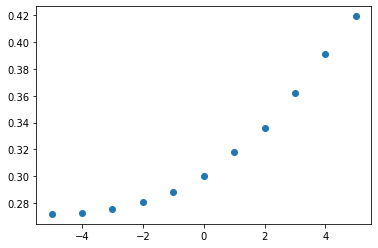

In [31]:

x,y, inds = get_batch(1, 100, 1,device)
# print(inds)
print(inds[0])
# print(model(x))
# print(y)
error_present(nn.Sigmoid()(model(x))[0], inds[0], y[0])
print(y)
print(nn.Sigmoid()(model(x)))

Despite literally everything I tried I could not get neither RNNs or LSTMs to actually work.